<a href="https://colab.research.google.com/github/orlandoalexander/Moda-Personal-Assistant/blob/playground/load_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications.mobilenet import preprocess_input
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image
from keras.applications.resnet import preprocess_input
from sys import getsizeof
import matplotlib.pyplot as plt
import requests
from io import BytesIO

In [34]:
from keras.preprocessing import image


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
classes = {
  "section": [
    "upper",
    "lower",
    "full body",
    "outfit"
  ],
  "category": [
    "Baggy_Pants",
    "Blouses",
    "Cardigans",
    "Dresses",
    "Graphic_Tees",
    "Jackets",
    "Joggers",
    "Pants",
    "Rompers",
    "Shirts",
    "Shorts",
    "Skirts",
    "Suiting",
    "Sweaters",
    "Tees"
  ],
  "design": [
    "floral",
    "graphic",
    "striped",
    "embroidered",
    "pleated",
    "solid",
    "lattice"
  ],
  "sleeves": [
    "long_sleeve",
    "short_sleeve",
    "sleeveless"
  ],
  "length": [
    "maxi_length",
    "mini_length"
  ],
  "neckline": [
    "crew_neckline",
    "v_neckline",
    "square_neckline",
    "no_neckline"
  ],
  "fabric": [
    "denim",
    "chiffon",
    "cotton",
    "leather",
    "faux",
    "knit"
  ],
  "fit": [
    "tight",
    "loose",
    "conventional"
  ]
}


In [31]:
design_model = tf.keras.models.load_model('/content/drive/MyDrive/Moda/saved_models/resnet_design_v1')

In [32]:
design_model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

In [7]:
def get_pad_color(image):
  left = image[:,0]
  right = image[:,-1]
  edge_color = int(np.concatenate((left, right)).mean())
  mean_color = (edge_color,edge_color)
  return mean_color

In [35]:
url = 'https://'+'images.asos-media.com/products/aape-by-a-bathing-ape-luxe-t-shirt-in-black/203648646-1-black'
response = requests.get(url)
im = Image.open(BytesIO(response.content))
IMAGE_SIZE = (224, 224)


In [36]:
# img = image.load_img('test1.jpg', target_size=(img_width, img_height))
x = image.img_to_array(im)
x = np.expand_dims(x, axis=0)

AttributeError: ignored

In [ ]:
images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)
print classes

ValueError: ignored

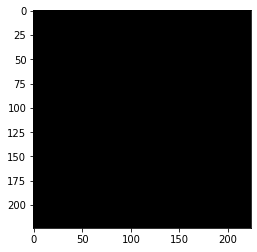

In [33]:
if im.shape[0] > im.shape[1]:
    scale = (IMAGE_SIZE[1]-1)/im.shape[0]
else:
    scale = (IMAGE_SIZE[0]-1)/im.shape[1]
scale_x, scale_y = (scale * dim for dim in im.shape[:-1])
x, y = np.ogrid[0:scale_x, 0:scale_y]
im = im[(x//scale).astype(int), (y//scale).astype(int)]
if im.shape[0] % 2 == 0:
    ax0_pad_left = ax0_pad_right = int((IMAGE_SIZE[1] - im.shape[0])/2)
else:
    dif = (IMAGE_SIZE[1] - im.shape[0])
    ax0_pad_left = int(dif/2)
    ax0_pad_right=0
    if dif > 0:
        ax0_pad_right = ax0_pad_left + 1
if im.shape[1] % 2 == 0:
    ax1_pad_left = ax1_pad_right = int((IMAGE_SIZE[0] - im.shape[1])/2)
else:
    dif = (IMAGE_SIZE[0] - im.shape[1])
    ax1_pad_left = int(dif/2)
    ax1_pad_right=0
    if dif > 0:
        ax1_pad_right = ax1_pad_left + 1
pad_color = get_pad_color(im)
cropped_pad_array = np.pad(im,pad_width=((ax0_pad_left, ax0_pad_right),(ax1_pad_left, ax1_pad_right),(0, 0)),constant_values=pad_color) # pad image with white background
im = preprocess_input(cropped_pad_array)
plt.imshow(cropped_pad_array)
result = design_model(im)
# post process result
predicted_class = tf.math.argmax(result[0], axis=-1)
print(predicted_class)
print(classes[design_model][predicted_class])
res = [(classes[design_model][index],val) for index, val in enumerate(result[0])]
res.sort(key=lambda x: x[1],reverse=True)
print(res)

In [21]:
cropped_pad_array.shape

(224, 224, 3)

In [22]:
print(im.shape)


(224, 224, 3)


In [25]:
im[0]

array([[-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-673.476, -697.232, -673.476],
       [-672.476, -696.232, -672.476],
       [-672.476, -696.23